In [1]:
import os
import pandas as pd
import numpy as np
import re
import zipfile
import copy
import time
import matplotlib.pyplot as plt
import copy
import glob
import seaborn as sns
import geopandas as gpd

### Functions For Street Category Identification

In [2]:
def make_edge_id_to_street_cat_dict():
    """
    Takes the sumo net, and assigns each link id to a street category.
    
    returns: a dictionary with sumo id as key and that id's street category as it's value.
    """
    
    def create_street_category(streetName):
        """
        Looks for keywords within a specific street name to assign it to a broader street category.
           The categories are curbside, internationalParkway or other.
        
        args:
        streetName: a string of the specific street name.
        
        returns: a string of the street category.
        """
        if (streetName is not None) and "terminal" in streetName.lower():
            return "curbside"
        elif (streetName is not None) and "internation" in streetName.lower():
            return "internationalParkway"
        else:
            return "other"
        
    net = gpd.read_file("./DFW_SUMO.geojson",driver='GeoJSON')
    net['streetCategory'] = net['streetName'].apply(lambda x: create_street_category(x))
    street_cat_dict = {pair[0]:pair[1] for pair in zip(net['SumoId'],net['streetCategory'])} 
    return street_cat_dict

#create the dictionary that links sumo link ids to street categories. 
street_cat_dict = make_edge_id_to_street_cat_dict()

def get_street_cat(edge_id):
    """
    Pull the street category from the sumo id dict and handle looking up an edge not in the network.
    
    args:
    edge_id: the sumo edge id within the DFW network
    
    returns: the street category "curbside", "internationalParkway" or "other" for any edge id in sumo
             and returns "other" for any edgeid not in the sumo network.
    """
    if edge_id in street_cat_dict.keys():
        return street_cat_dict[edge_id]
    else:
        return "other"
##ex of calling the function:
#output_metrics_df['streetCategory'] = output_metrics_df['edge_id'].apply(lambda x: get_street_cat(x))

### Function to get statistics from the sumo output files edges_out.csvs or edge_emissions.csvs

In [3]:
def make_stat_df(file, colname, operation, file_type = "edges_out",
                 daily_cumulative = False,
                 pct = None, plot_with_error = False, error_type = "sem",
                 group_on_street_cat = False):
    """
    Perform statistical calculations on a given dataframe from "file" and "colname". 
    
    Args:
    file: the name of the file path and file containing the csv of data.
    colname: the name of the column on which to perform the statistical operation.
    operation: statistical operation you would like performed on the column withing each interval group
                (e.g. if sumo is reporting outputs in hourly intervals, the data will be grouped by hour);
                currently accepting: min, max, mean, sum or quantile.
    file_type: the type of file (either "edges_out" or "emissions") from sumo to be analyzed.
    daily_cumulative: boolean for if you would like to calcuate a cumulative sum of values within each day.
    pct: only relevant if "quantile" is the operation. a value between 0 and 1 indicating which quantile you want
         to calculate.
    plot_with_error: a boolean indicating whether you would like an error column generated
    error_type: "sem" or "std" accepted to indicate which type of error you would like calcuated.
    group_on_street_cat: boolean indicating whether you'd like the data to be grouped in terms of the street
                         category of links (curbside, internationalParkway, or other)

    Returns: 
    4 objects: (1) a yeardf which is the dataframe with given statistical information calculated from the data.
    (2, 3, and 4) grouped_colname, error_colname, and cumulative_colname are all strings which need to be returned
    to the plotting function which calls this function so that those columns can be graphed correctly.
    """
    error_colname = None
    cumulative_colname = None
    output_metrics_df = pd.read_csv(file, sep = ";")
    output_metrics_df.drop(list(output_metrics_df.filter(regex = 'Unnamed')), axis = 1, inplace = True)
    if file_type == "edges_out":
        output_metrics_df.dropna(subset = ['edge_traveltime', 'edge_overlapTraveltime',
                                           'edge_density', 'edge_occupancy', 'edge_waitingTime',
                                           'edge_speed'],
                             inplace = True)
    elif file_type == "edge_emmisions":
        output_metrics_df.dropna(subset = ['edge_fuel_abs', 'edge_fuel_normed'],
                                 inplace = True)
    if colname == "edge_flow":
        output_metrics_df['edge_flow'] = output_metrics_df['edge_speed'] * 3.6 * output_metrics_df['edge_density']
    if group_on_street_cat:
        output_metrics_df['streetCategory'] = output_metrics_df['edge_id'].apply(lambda x: get_street_cat(x))
        year_df = output_metrics_df[[colname, 'interval_begin', 'streetCategory']]
        groupby_columns = ['interval_begin', 'streetCategory']
    else: 
        year_df = output_metrics_df[[colname, 'interval_begin']]
        groupby_columns = ['interval_begin']
    
    if plot_with_error == True:
        error_df = copy.copy(year_df)
        if error_type.lower() == "sem":
            error_df = error_df.groupby(groupby_columns).sem().reset_index()               
            error_colname = "standard_error_of_the_mean"
            error_df.rename(axis = 'columns', mapper = {colname: error_colname}, inplace = True)
        elif error_type.lower() == "std":
            error_df = error_df.groupby(groupby_columns).std().reset_index()
            error_colname = "standard_deviation"
            error_df.rename(axis = 'columns', mapper = {colname: error_colname}, inplace = True)
        else:
            assert error_type in ['sem', 'std'], "error_type must be given as either sem or std"

    operation = operation.lower()
    if operation == "max":
        year_df = year_df.groupby(groupby_columns).max().reset_index()
    elif operation == "mean":
        year_df = year_df.groupby(groupby_columns).mean().reset_index()
    elif operation == "sum":
        year_df = year_df.groupby(groupby_columns).sum().reset_index()
    elif operation == "min":
        year_df = year_df.groupby(groupby_columns).min().reset_index()
    elif operation == "quantile":
        if pct is None: 
            assert pct is not None, "need to give a percentage for the quantile to calculate with pct arg"
        else:
            year_df = year_df.groupby(groupby_columns).quantile(pct).reset_index()
    else: 
        assert operation in ["max", "min", "mean", "sum", "quantile"], "operation must be one of ['max', 'min', 'mean', 'sum', 'quantile']"

    if plot_with_error == True: 
        year_df = pd.merge(year_df, error_df, how = 'left', on = groupby_columns)

    grouped_colname = colname + "_" + operation
    year_df.rename(axis = 'columns', mapper = {colname: grouped_colname}, inplace = True)
    if daily_cumulative == True:
        cumulative_colname = "daily_cumulative_" + grouped_colname
        year_df[cumulative_colname] = year_df[grouped_colname].cumsum()
    year_df['intervalBeginHours'] = year_df['interval_begin']/3600
    year_df['year'] = int(file.split("_")[-3])
    return year_df, grouped_colname, error_colname, cumulative_colname

### Functions to make graphs for a single scenario

#### Based on edges_out or edge_emmisions to create a timeseries graph...

In [4]:
def make_timeseries_graph(fp_in, fp_out, savename_tag, file_type, colname,
                         operation, y_axis_label, fig_title_str,
                         savefig_title_str, hline_height = None,
                         daily_cumulative = False,
                         pct = None, plot_with_error = False,
                         error_type = "sem",
                         min_year = 0, max_year = 30):
    """
    For a given column in the sumo output "edges_out" or "edge_emmisions", this will generate a graph.
    operation is the operation you'd like performed on the groupby such as mean, min, max, quantile.
    
    args:
    fp_in:   a string of the input filepath to a folder containing sumo output files
    fp_out:   a string of the output filepath to a folder in which you'd like the graph image stored
    savename_tag:   a string that will be added to the end of the name of the saved image, before .png
                    to help keep different simulation runs organized. can be an empty string "".
    file_type: a string of either "edges_out" or "edge_emmisions" for which type of sumo output file you'd
               like to be graphed.
    colname: a string of the column name within the given type of sumo output file that you want to graph
    operation: statistical operation you would like performed on the column within each interval group
                (e.g. if sumo is reporting outputs in hourly intervals, the data will be grouped by hour);
                currently accepting: min, max, mean, sum or quantile.
    y_axis_label: a string for what label you'd like the y axis of the graph to have
    fig_title_str: a string of the title you'd like the graph to have
    savefig_title_str: a string for what you'd like the filename of the graph to be (the savename_tag and .png
                       will be added to this string)
    hline_height: (optional) a float of the y-axis value at which you'd like like a horizontal line added to 
                   the graph. e.g. to use as a reference for checking if a trend is increasing over time
    daily_cumulative: a boolean indicating if you'd like to plot the cumulative sum of values throughout the day
    pct: only relevant if "quantile" is the operation. a value between 0 and 1 indicating which quantile you want
         to calculate.
    plot_with_error: a boolean indicating whether you would like an error column generated
    error_type: a string of "sem" or "std" to indicate which type of error you would like calcuated.
    min_year: integer of the minimum year (starting at 0 for 2018) to be included in the graphs.
    max_year: integer of the maximum year (starting at 0 for 2018) to be included in the graphs.
    
    returns: a dataframe with time columns, the column with the desired operation performed and error
             or cumulative columns if those were selected.
    *SAVES* a graph of the given column with the desired operation performed, and error bars if selected
            (saved to the fp_out folder).
    """
    count = 0
    if file_type == "edges_out":
        files = sorted(glob.glob(fp_in + "*_edges_out.csv"), key = lambda file: int(file.split("_")[-3]))
    elif file_type == "edge_emmisions":
        files = sorted(glob.glob(fp_in + "*_edge_emmisions.csv"), key = lambda file: int(file.split("_")[-3]))
    else:
        assert file_type in ["edges_out", "edge_emmisions"], "file type must be either edges_out or edge_emmisions"

    for file in files:
        year = int(file.split("_")[-3])
        if year >= min_year and year <= max_year:
            year_df, grouped_colname, error_colname, cumulative_colname = make_stat_df(file, colname, operation,
                                                                                       file_type = file_type,
                                                                                       daily_cumulative = daily_cumulative,
                                                                                       pct = pct,
                                                                                       plot_with_error = plot_with_error,
                                                                                       error_type = error_type)
            if count == 0:
                years_df = copy.copy(year_df)
            else:
                years_df = pd.concat([years_df, year_df], axis = 0)
            count=count+1
    years_df['hour_fraction'] = years_df['intervalBeginHours']/24
    years_df['time'] = years_df['year'] + years_df['hour_fraction'] + 2018
    fig, ax = plt.subplots(figsize = (15,5))
    if daily_cumulative == True:
        ax.plot(years_df['time'], years_df[cumulative_colname])
    elif daily_cumulative == False and plot_with_error == False:
        ax.plot(years_df['time'], years_df[grouped_colname])
    else:
        ax.errorbar(years_df['time'], years_df[grouped_colname], xerr = 0, 
             yerr = years_df[error_colname])
    #ax.set_xlabel("Years from 2018 (within each year, data given every half hour for a sample day)")
    ax.set_xlabel("Year (within each year, data given for a sample day)")
    ax.set_ylabel(y_axis_label)
    if hline_height != None:
        ax.axhline(hline_height, linewidth = "0.3")
    plt.suptitle(fig_title_str)
    plt.savefig(fp_out + savefig_title_str + savename_tag + ".png")
    years_df = years_df[['year', 'interval_begin', "intervalBeginHours", grouped_colname]]
    return years_df

#### based on *_summary.csv files from sumo outputs to create a timeseries graph

In [5]:
def make_sumo_summary_graph(fp_in, fp_out, savename_tag, colname,
                            operation, y_axis_label, fig_title_str,
                            savefig_title_str, show_x_years):
    """
    Makes and saves a graph based on the sumo summary output file. Returns the dataframe used to make the graph.
    
    args:
    fp_in:   a string of the input filepath to a folder containing sumo summary output files
    fp_out:   a string of the output filepath to a folder in which you'd like the graph image stored
    savename_tag:   a string that will be added to the end of the name of the saved image, before .png
                    to help keep different simulation runs organized. can be an empty string "".
    colname: a string of the column name within the sumo summary output file that you want to graph
    operation: statistical operation you would like performed on the column to get a yearly aggregate value...
                currently accepting: min, max, mean, sum, quantile, sem or std.
    y_axis_label: a string for what label you'd like the y axis of the graph to have
    fig_title_str: a string of the title you'd like the graph to have
    savefig_title_str: a string for what you'd like the filename of the graph to be (the years shown
                        as well as the savename_tag and .png will be added to this string) 
    show_x_years: a float of the number of years you'd like to graph. Will graph from year 0 (2018)
                  to the year that you specify. If your data has less than this many
                  years, there won't be an error, it will just graph all the years you have.
                  
    returns: a dataframe of the desired aggregation on the desired column and timestamp columns included.
    *SAVES* a png of the graph to the fp_out folder.
    """
    files = sorted(glob.glob(fp_in + "*_summary.csv"), key = lambda file: int(file.split("_")[-2]))
    count = 0

    for file in files:
        if int(file.split("_")[-2]) < show_x_years:
            df = pd.read_csv(file, sep = ";")
            
            if operation == "max":
                yearly_value = df[colname].max()
            elif operation == "mean":
                yearly_value = df[colname].mean()
            elif operation == "std":
                yearly_value = df[colname].std()
            elif operation == "sum":
                yearly_value = df[colname].sum()
            elif operation == "sem":
                yearly_value = df[colname].sem()
            elif operation == "min":
                yearly_value = df[colname].min()
            else: 
                assert operation in ["max", "min", "mean", "sum", "std", "sem"], "operation must be one of ['max', 'min', 'mean', 'sum', 'std', 'sem']"
            
            year = int(file.split("_")[-2])
            year_df = pd.DataFrame({'year': [year], colname: [yearly_value]})
            if count == 0:
                years_df = copy.copy(year_df)
            else:
                years_df = pd.concat([years_df, year_df], axis = 0)
            count=count+1

    years_df['year'] = years_df['year'] + 2018
    fig, ax = plt.subplots(figsize = (15,5))
    ax.plot(years_df['year'], years_df[colname])
    ax.set_xlabel("Years (within each year, data given for a sample day)")
    ax.set_ylabel(y_axis_label)
    plt.suptitle(fig_title_str)
    save_str = savefig_title_str + "_for_" + str(years_df.year.max()) + "_years_" + savename_tag + ".png"
    plt.savefig(fp_out + save_str)
    return years_df

#### From the edges out file - not timeseries - to compare two columns vs. each other...

In [6]:
def make_spd_vs_density_scatter_raw(fp_in, fp_out, savename_tag, min_year, max_year):
    """
    Using the edges_out output from sumo, create scatterplot of speed vs. density for given years. 
    
    args:
    fp_in:   a string of the input filepath to a folder containing sumo edge-based output files
    fp_out:   a string of the output filepath to a folder in which you'd like the graph image stored
    savename_tag:   a string that will be added to the end of the name of the saved image, before .png
                    to help keep different simulation runs organized. can be an empty string "".
    min_year: integer of the minimum year (starting at 0 for 2018) to be included in the graphs.
    max_year: integer of the maximum year (starting at 0 for 2018) to be included in the graphs.
    
    returns: a dataframe that has concatonated the csvs from the given years.
    *SAVES* a scatter plot of the speed vs. density columns for the stated years.
    """
    files = sorted(glob.glob(fp_in + "*_edges_out.csv"), key = lambda file: int(file.split("_")[-3]))
    count = 0

    for file in files:
        if (int(file.split("_")[-3]) >= min_year) and (int(file.split("_")[-3]) <= max_year):
            df = pd.read_csv(file, sep = ";")
            df['year'] = int(file.split("_")[-3])
            df['speed'] = df['edge_speed']*2.23694 #m/s to mph conversion
            df['density'] = df['edge_density']*1.60934 #km/mile b/c (veh/km)*(km/mile) = veh/mile
            year_df = copy.copy(df[['year', 'interval_begin', 'speed', 'density']])
            if count == 0:
                years_df = copy.copy(year_df)
            else:
                years_df = pd.concat([years_df, year_df], axis = 0)
            count=count+1

    fig, ax = plt.subplots(figsize = (13,10))
    ax.scatter(years_df['speed'], years_df['density'])
    ax.set_xlabel("Vehicle Speed Mph (avg. per link per unit time)")
    ax.set_ylabel("Vehicle Density (veh/mile)")
    plt.suptitle("Speed Vs. Density Plot From Year " + str(min_year) + " to Year " + str(years_df['year'].max()))
    save_str =  "speedVsDensityPlot_from_year_" + str(min_year) + "_to_" + str(years_df['year'].max()) + savename_tag + ".png"
    plt.savefig(fp_out + save_str)
    return years_df

In [7]:
def make_avg_speed_vs_density_graph(fp_in, fp_out, savename_tag, file_type = "edges_out",
                                    min_year = 0, max_year = 28,
                                    col_1 = 'edge_density', col_2 = 'edge_speed', operation = "mean",
                                    daily_cumulative = False, group_on_street_cat = False,
                                    alpha = 1.,
                                    xlabel = "Vehicle Density (veh/mile)",
                                    ylabel = "Vehicle Speed Mph (avg. per link per unit time)",
                                    fig_title_start = "Average Speed Vs. Density Plot",
                                    fig_title_end = "",
                                    save_fig_name = "avgSpeedVsDensityPlot"):
    """
    graphs two columns versus each other with time shown in the size of points (year) and color (time of day)
        the columns are first aggregated with the "operation" parameter before being graphed.
        colname can be "edge_flow" even though this is not a regular output column of edges_out. 
                
    args:
    fp_in:   a string of the input filepath to a folder containing sumo edge-based output files.
    fp_out:   a string of the output filepath to a folder in which you'd like the graph image stored.
    savename_tag:   a string that will be added to the end of the name of the saved image, before .png
                    to help keep different simulation runs organized. can be an empty string "".
    file_type: a string of the sumo output file type that you will be making your graph from.
               options are: "edges_out" or "edge_emmisions"
    min_year: integer of the minimum year (starting at 0 for 2018) to be included in the graphs.
    max_year: integer of the maximum year (starting at 0 for 2018) to be included in the graphs.
    col_1: a string of the column name that you would like aggregated & graphed on the x-axis.
           Colname can be "edge_flow" even though this is not a regular output column of edges_out - 
           it will be the flow in units of the number of vehicles passing a point per hour.
           "density" will be given as vehicles/mile & "speed" as mph.
    col_2: a string of the column name that you would like aggregated & graphed on the y-axis.
           colname can be "edge_flow" even though this is not a regular output column of edges_out - 
           it will be the flow in units of the number of vehicles passing a point per hour.
           "density" will be given as vehicles/mile & "speed" as mph.
    operation: statistical operation you would like performed on the column withing each interval group
                (e.g. if sumo is reporting outputs in hourly intervals, the data will be grouped by hour);
                currently accepting: min, max, mean, sum or quantile. 
    daily_cumulative: boolean for if you would like to calcuate a cumulative sum of values within each day.
    group_on_street_cat: boolean indicating whether you'd like the data to be grouped in terms of the street
                         category of links (curbside, internationalParkway, or other)
    alpha: specifies the transparency of points (0 completely transparent, 1 solid) since points may be overlapping.
    xlabel: a string of the x-axis lable (should update if you change the default col_1 value)
    ylabel: a string of the y-axis label (should update if you change the default col_2 value)
    fig_title_start: a string of the beginning graph title; before "between years _min_ and _max_" is stated.
    fig_title_end: a string of the end of the graph title; after "between years _min_ and _max_" is stated.
    save_fig_name: a string for the name you would like the graph saved with (min/max year and savename_tag will
                    be added to the end of this string).
    
    returns: a dataframe with the given columns, aggregated as specified for the stated years.
    *SAVES* a scatter plot of the given column names for the stated years.
    """
    col_1_conversion_factor = 1.
    col_2_conversion_factor = 1.
    if "density" in col_1:
        col_1_conversion_factor = 1.60934 #km/mile b/c (veh/km)*(km/mile) = veh/mile
    if "density" in col_2:
        col_2_conversion_factor = 1.60934 #km/mile b/c (veh/km)*(km/mile) = veh/mile
    if "speed" in col_1:
        col_1_conversion_factor = 2.23694 #m/s to mph conversion
    if "speed" in col_2:
        col_2_conversion_factor = 2.23694 #m/s to mph conversion
    
    
    count = 0
    if file_type == "edges_out":
        files = sorted(glob.glob(fp_in + "*_edges_out.csv"), key = lambda file: int(file.split("_")[-3]))
    elif file_type == "edge_emmisions":
        files = sorted(glob.glob(fp_in + "*_edge_emmisions.csv"), key = lambda file: int(file.split("_")[-3]))
    else:
        assert file_type in ["edges_out", "edge_emmisions"], "file type must be either edges_out or edge_emmisions"

    for file in files:
        year = int(file.split("_")[-3])
        if year >= min_year and year <= max_year:
            year_df_1, grouped_colname_1, error_colname, cumulative_colname_1 = make_stat_df(file, col_1, operation,
                                                                                             file_type = file_type,
                                                                                             daily_cumulative = daily_cumulative,
                                                                                             plot_with_error = False, 
                                                                                             group_on_street_cat = group_on_street_cat)
            year_df_2, grouped_colname_2, error_colname, cumulative_colname_2 = make_stat_df(file, col_2, operation,
                                                                                             file_type = file_type,
                                                                                             daily_cumulative = daily_cumulative,
                                                                                             plot_with_error = False,
                                                                                             group_on_street_cat = group_on_street_cat)
            if group_on_street_cat:
                year_df = pd.merge(year_df_1, year_df_2, how = 'left', on = ['year', 'interval_begin',
                                                                             'intervalBeginHours',
                                                                             'streetCategory'])
            else:
                year_df = pd.merge(year_df_1, year_df_2, how = 'left', on = ['year', 'interval_begin',
                                                                         'intervalBeginHours'])
            if count == 0:
                years_df = copy.copy(year_df)
            else:
                years_df = pd.concat([years_df, year_df], axis = 0)
            count=count+1
    years_df['hour_fraction'] = years_df['intervalBeginHours']/24
    years_df['year'] = years_df['year'] + 2018
    years_df['time'] = years_df['year'] + years_df['hour_fraction']
    years_df[grouped_colname_1] = years_df[grouped_colname_1]*col_1_conversion_factor
    years_df[grouped_colname_2] = years_df[grouped_colname_2]*col_2_conversion_factor
    fig, ax = plt.subplots(figsize = (15,5))
    if daily_cumulative:
        if group_on_street_cat: 
            sns.scatterplot(years_df[cumulative_colname_1], years_df[cumulative_colname_2],
                            hue = years_df['intervalBeginHours'], size = years_df['year'],
                            style = years_df['streetCategory'], alpha = alpha)
        else:
            sns.scatterplot(years_df[cumulative_colname_1], years_df[cumulative_colname_2],
                            hue = years_df['intervalBeginHours'], size = years_df['year'], alpha = alpha)
    else:
        if group_on_street_cat:
            sns.scatterplot(years_df[grouped_colname_1], years_df[grouped_colname_2],
                            hue = years_df['intervalBeginHours'], size = years_df['year'], 
                            style = years_df['streetCategory'], alpha = alpha)
        else:
            sns.scatterplot(years_df[grouped_colname_1], years_df[grouped_colname_2],
                            hue = years_df['intervalBeginHours'], size = years_df['year'], alpha = alpha)
                        #palette = sns.color_palette(n_colors = 9))
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.suptitle(fig_title_start + " From " + str(min_year+2018) + " to " + str(max_year + 2018) + fig_title_end)
    if group_on_street_cat:
        save_str = save_fig_name + "_from_year_" + str(years_df['year'].min()) + "_to_" + str(years_df['year'].max()) + \
                   "_WithStreetCat_" + savename_tag + ".png"
    else:
        save_str =  save_fig_name + "_from_year_" + str(years_df['year'].min()) + "_to_" + str(years_df['year'].max()) + \
                    "_" + savename_tag + ".png"
    plt.savefig(fp_out + save_str)
    return years_df

#### To look at changes in mode over time...

In [8]:
def make_mode_graph(fp_in, fp_out, savename_tag, graph_type = "proportion", max_year = 28, min_year = 0):
    
    """
    Using the trip outputs from sumo, graphs the proportions or raw values of variuos mode choices for each year.
    
    args:
    fp_in:   a string of the input filepath to a folder containing sumo edge-based output files.
    fp_out:   a string of the output filepath to a folder in which you'd like the graph image stored.
    savename_tag:   a string that will be added to the end of the name of the saved image, before .png
                    to help keep different simulation runs organized. can be an empty string "".
    graph_type: a string of either proportion or any other string. If proportion, the mode choices will be
                graphed as proportions of overall trips; any other string will graph the raw values of mode choices.
    max_year: the maximum year to be graphed starting from 0 (which corresponded to 2018 for our analyses)
    min_year: the minimum year to be graphed starting from 0 (which corresponded to 2018 for our analyses)
    
    returns: a dataframe with the mode choice distribution per year.
    *SAVES* a graph of the mode choice distributions over the given years.
    """
    
    def transform_tripID_to_mode(x):
        """
        Takes more specific trip information & converts it to a broader mode choice type.
        
        args:
        x: a string of tripID information given by sumo in the trip outputs files.
        """
        if '_passenger_' in x:
            return "passenger"
        elif '_TNC_' in x:
            return "TNC"
        elif '_Taxi_' in x:
            return "taxi"
        elif '_parking_' in x:
            return "parking"
        elif '_Limo_' in x:
            return "limo"
        elif "Rental" in x:
            return "rental"
        elif "pass_" in x:
            return "passThrough"
        else:
            return "None"
    
    if graph_type == "proportion":
        y_label = "Proportion of Mode Chosen"
        fig_title_beginning = "Proportion of Modes Chosen Over "
        savefig_title_str_beginning = "proportionModeChosenOver"
    else:
        y_label = "Number of Trips Taken Per Mode"
        fig_title_beginning = "Number of Trips Taken Per Mode Over "
        savefig_title_str_beginning = "NumberTripsPerModeOver"
    
    count = 0
    files = sorted(glob.glob(fp_in + "*trip_outputs.csv"), key = lambda file: int(file.split("_")[-3]))
    if graph_type == "proportion":
        years_df = pd.DataFrame(columns = ['year', 'prop_passenger', 'prop_tnc', 'prop_taxi',
                                           'prop_limo', 'prop_park', 'prop_passThrough', 'prop_rental',
                                           'prop_none'])
    else: 
        years_df = pd.DataFrame(columns = ['year', 'passenger', 'TNC', 'taxi', 'limo',
                                           'parking', 'passThrough', 'rental', 'None'])
    
    for file in files:
        df = pd.read_csv(file, sep = ";")
        year = int(file.split("_")[-3])
        if (year >= min_year) and (year <= max_year):
            df['mode_choice'] = df.tripinfo_id.apply(lambda x: transform_tripID_to_mode(x))

            counts = df.mode_choice.value_counts()
            psx = counts['passenger']
            tnc = counts['TNC']
            taxi = counts['taxi']
            limo = counts['limo']
            park = counts['parking']
            passThrough = counts['passThrough']
            if 'rental' in counts.keys():
                rental = counts['rental']
            else:
                rental = 0
            none = counts['None']

            if graph_type == "proportion":
                prop_psx = psx/sum(counts)
                prop_tnc = tnc/sum(counts)
                prop_taxi = taxi/sum(counts)
                prop_limo = limo/sum(counts)
                prop_park = park/sum(counts)
                prop_pass = passThrough/sum(counts)
                prop_rental = rental/sum(counts)
                prop_none = none/sum(counts)

            if graph_type == "proportion":  
                years_df = years_df.append({'year': year, 'prop_passenger': prop_psx, 'prop_tnc': prop_tnc,
                                            'prop_taxi': prop_taxi, 'prop_limo': prop_limo,
                                            'prop_park': prop_park, 'prop_passThrough': prop_pass,
                                            'prop_rental': prop_rental,'prop_none': prop_none}, ignore_index = True)
            else:
                years_df = years_df.append({'year': year, 'passenger': psx, 'TNC': tnc, 'taxi': taxi,
                                            'limo': limo, 'parking': park, 'passThrough': passThrough,
                                            'rental': rental, 'None':none}, ignore_index = True)

        
    years_df['year'] = years_df['year'] + 2018
    years_df.set_index("year", inplace = True)
    fig, ax = plt.subplots(figsize = (15,5))
    years_df.plot.area(ax=ax)
    ax.set_xlabel("Years")
    ax.set_ylabel(y_label)
    plt.suptitle(fig_title_beginning + str(len(years_df)) + " Years")
    plt.savefig(fp_out + savefig_title_str_beginning + str(len(years_df)) + "Years_" + savename_tag + ".png")
    return years_df

### Code to graph multiple scenarios on the same graph...
#### For edges_out or edge_emmisions csvs...

In [9]:
def make_timeseries_multi_graph(fps_in, fp_out, col_tags, savename_tag, file_type, colname,
                                operation, y_axis_label, fig_title_str,
                                savefig_title_str, conversion_factor=1, hline_height = None,
                                pct = None, plot_with_error = False,
                                error_type = "sem",
                                colors = ["blue"], min_year = 0, max_years = 28, alphas = [1.], 
                                labels = [], 
                                annotate = False, annot_agg_type = "sum", 
                                day_type_fraction_of_year = 0.33,
                                units = "", unitsOf = ""):
    """
    Graphs multiple different scenarios over the same time period for comparison purposes.
    
    fps_in: a list of strings that contain the file paths to the sumo outputs folders that you want graphed
            ***if annotate is true, list the base_case file path first to get the right amount saved***
    fp_out:   a string of the output filepath to a folder in which you'd like the graph image stored.
    col_tags: a list of strings. Each string should specify a code name for each different scenario that
              you want graphed as a separate line on the plot; these will be added to the column names in the 
              return data frame. The list should be the same length & order as fps_in.
    savename_tag:   a string that will be added to the end of the name of the saved image, before .png
                    to help keep different simulation runs organized. can be an empty string "".
    file_type: a string of the sumo output file type that you will be making your graph from.
               options are: "edges_out" or "edge_emmisions".
    colname: the column name from the specified file_type  which you would like to be graphed. E.g. 'edge_CO2_abs'
    operation: statistical operation you would like performed on the column withing each interval group
                (e.g. if sumo is reporting outputs in hourly intervals, the data will be grouped by hour);
                currently accepting: min, max, mean, sum or quantile. 
    y_axis_label: the y-axis label, should correspond to the colname chosen.
    fig_title_str: a string of the title for the graph figure.
    savefig_title_str: a string of the filename you would like the graph to be saved as (savename_tag will be added 
                       to this)
    conversion_factor: a float value if you would like to change the units of the y-axis.
                       for example: "edge_CO2_abs" is given in mg, you could specify a conversion factor of 1e-6 to
                                    convert to kg.
                       If set to 1, this will not change the units of the y-axis at all.
    hline_height: y-axis value for a horizontal line to be added to the plot, in the event that you're looking
                  for small trends over time or want to see if the y-axis crosses a certain threshold value.
    pct: only relevant if "quantile" is the operation. a value between 0 and 1 indicating which quantile you want
         to calculate.
    plot_with_error: a boolean indicating whether you would like an error column generated
    error_type: "sem" or "std" accepted to indicate which type of error you would like calcuated.
    colors: a list of strings specifying the colors of the lines in the graph for each scenario.
            The length & order of the list must match the length & order of the lists in fps_in and col_tags.
    min_year: the minimum year to be graphed starting from 0 (which corresponded to 2018 for our analyses)
    max_years: the maximum year to be graphed starting from 0 (which corresponded to 2018 for our analyses)
    alphas: a list of integers specifying the transparency (0 -transparent, 1-solid) of the lines in the graph
            for the different scenarios. Must be same length & order as fps_in, col_tags & colors.
    labels: a list of strings in the same order as fps that say what each line is, no beginning underscore please
            e.g. ["base_case", "transit_ten_pct", "transit_five_pct"]. These will create the legend of the graph.
    annotate: boolean indicating if you want to show how much of x parameter was saved with your simulation
              compared to the base case (base case must be the first filepath given in fps_in, and the comparison
              scenarios can be listed after that). 
    annot_agg_type: either "sum" or "mean". Either sums or takes the average of the y-axis value for all years.
                    So that the annotation will either describe the average or total savings with a given scenario
                    compared to the base case (listed first in fps_in)
    units: string of the y-axis units to be used in the graph annotation. e.g. "mg"
    unitsOf: string of the y-axis value. e.g. "CO2"
    
    returns: a dataframe of the given column aggregated as specified for the given years, for each input scenario.
    *SAVES* a graph of all the scenarios for the given attribute and years.
    """
    big_count = 0
    grouped_colnames = []
    error_colnames = []
    for fp_in in fps_in:
        col_tag = col_tags[big_count]
        count = 0
        if file_type == "edges_out":
            files = sorted(glob.glob(fp_in + "*_edges_out.csv"), key = lambda file: int(file.split("_")[-3]))
        elif file_type == "edge_emmisions":
            files = sorted(glob.glob(fp_in + "*_edge_emmisions.csv"), key = lambda file: int(file.split("_")[-3]))
        else:
            assert file_type in ["edges_out", "edge_emmisions"], "file type must be either edges_out or edge_emmisions"

        for file in files:
            if (int(file.split("_")[-3]) <= max_years) and (int(file.split("_")[-3]) >= min_year): 
                year_df, grouped_colname, error_colname, cumulative_colname = make_stat_df(file, colname, operation,
                                                                                           file_type = file_type,
                                                                                           pct = pct,
                                                                                           plot_with_error = plot_with_error,
                                                                                           error_type = error_type)
                if count == 0:
                    years_df = copy.copy(year_df)
                else:
                    years_df = pd.concat([years_df, year_df], axis = 0)
                count=count+1
        years_df['hour_fraction'] = years_df['intervalBeginHours']/24
        years_df['time'] = years_df['year'] + years_df['hour_fraction'] + 2018
        years_df[grouped_colname] = years_df[grouped_colname]*conversion_factor
        years_df = years_df.round({'time': 3})
        if big_count == 0:
            full_df = copy.copy(years_df)
            grouped_colnames.append(grouped_colname)
            if plot_with_error: 
                error_colnames.append(error_colname)
        else:
            #print(full_df)
            #print(years_df)
            full_df = pd.merge(full_df, years_df, how = 'outer', on = ['time'], suffixes = ["", col_tag])
            new_grouped_name = grouped_colname + col_tag
            grouped_colnames.append(new_grouped_name)
            if plot_with_error:
                new_error_name = error_colname + col_tag
                error_colnames.append(new_error_name)
        big_count += 1

    #full_df = full_df[full_df['year'] <= max_years]
    #print(full_df)
    
    #information for graph annotations saying how much was saved with each scenario.
    count = 0
    dict_of_savings = {}
    annot_str_list = []
    for column in grouped_colnames: 
        if count == 0: 
            if annot_agg_type == "sum":
                #mult by 365 because only aggregating for one day sample day each year.
                base_case_number = full_df[column].sum()
            elif annot_agg_type == "mean":
                base_case_number = full_df[column].mean()
        else:
            if annot_agg_type == "sum":
                savings = base_case_number - full_df[column].sum()
            elif annot_agg_type == "mean":
                savings = base_case_number - full_df[column].mean()
            dict_of_savings[column] = savings
            annot_str = "With " + labels[count] + " strategy, " + \
                         str(int(savings)) + " " + units + " " + unitsOf + " were saved"
            annot_str_list.append(annot_str)
        count += 1
    
    fig, ax = plt.subplots(figsize = (15,5))
    if plot_with_error:
        for i in range(len(fps_in)):
            ax.errorbar(full_df['time'], full_df[grouped_colnames[i]], xerr = 0, 
                        yerr = full_df[error_colnames[i]], color = colors[i], alpha = alphas[i],
                        label = labels[i])
    else:
        for i in range(len(fps_in)):
            ax.plot(full_df['time'], full_df[grouped_colnames[i]], color = colors[i], alpha = alphas[i],
                    label=labels[i]) 

    if annotate:
        count = 0
        for x in annot_str_list: 
            ax.annotate(annot_str_list[count], xy = (0.6, 01. - count/20), xycoords = "axes fraction")
            count += 1
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("Year (within each year, data given for a sample day)",
                  fontsize = 16)
    ax.set_ylabel(y_axis_label, fontsize = 16, wrap = True)
    ax.legend()
    if hline_height != None:
        ax.axhline(hline_height, linewidth = "0.3")
    plt.suptitle(fig_title_str, fontsize = 20)
    plt.savefig(fp_out + savefig_title_str + savename_tag + ".png")
    return full_df

#### For the summary csvs...

In [10]:
def make_sumo_summary_multi_graph(fps_in, fp_out, col_tags, savename_tag, colname,
                                  operation, y_axis_label, fig_title_str,
                                  savefig_title_str, show_x_years, colors = ["blue"], alpha = 1.):
    """
    Graphs multiple scenarios as lines on a timeseries plot based on a column of the sumo summary outputs files, 
      aggregated as specified.
    
    args: 
    fps_in: a list of strings that contain the file paths to the sumo outputs folders that you want graphed
    fp_out:   a string of the output filepath to a folder in which you'd like the graph image stored.
    col_tags: a list of strings. Each string should specify a code name for each different scenario that
              you want graphed as a separate line on the plot; these will be added to the column names in the 
              return data frame. The list should be the same length & order as fps_in.
    savename_tag:   a string that will be added to the end of the name of the saved image, before .png
                    to help keep different simulation runs organized. can be an empty string "".
    colname: the column name from sumo summary outputs which you would like to be graphed. 
    operation: statistical operation you would like performed on the column withing each interval group
                (e.g. if sumo is reporting outputs in hourly intervals, the data will be grouped by hour);
                currently accepting: min, max, mean, sum or std or sem. 
    y_axis_label: the y-axis label, should correspond to the colname chosen.
    fig_title_str: a string of the title for the graph figure.
    savefig_title_str: a string of the filename you would like the graph to be saved as (savename_tag will be added 
                       to this)
    show_x_years: the number of years to be included (starting from 0, which corresponded to 2018 for our analyses)
    colors: a list of strings specifying the colors of the lines in the graph for each scenario.
            The length & order of the list must match the length & order of the lists in fps_in and col_tags.
    alphas: An integers specifying the transparency (0 -transparent, 1-solid) of the lines in the graph.
    
    returns: A dataframe of the column aggregated as specified for the given years for each scenario chosen.
    *SAVES* a graph of the given column and years for each scenario.
    """
    
    big_count = 0
    colnames = []
    for fp_in in fps_in:
        col_tag = col_tags[big_count]
        files = sorted(glob.glob(fp_in + "*_summary.csv"), key = lambda file: int(file.split("_")[-2]))
        count = 0

        for file in files:
            if int(file.split("_")[-2]) < show_x_years:
                df = pd.read_csv(file, sep = ";")

                if operation == "max":
                    yearly_value = df[colname].max()
                elif operation == "mean":
                    yearly_value = df[colname].mean()
                elif operation == "std":
                    yearly_value = df[colname].std()
                elif operation == "sum":
                    yearly_value = df[colname].sum()
                elif operation == "sem":
                    yearly_value = df[colname].sem()
                elif operation == "min":
                    yearly_value = df[colname].min()
                else: 
                    assert operation in ["max", "min", "mean", "sum", "std", "sem"], "operation must be one of ['max', 'min', 'mean', 'sum', 'std', 'sem']"

                year = int(file.split("_")[-2])
                year_df = pd.DataFrame({'year': [year], colname: [yearly_value]})
                if count == 0:
                    years_df = copy.copy(year_df)
                else:
                    years_df = pd.concat([years_df, year_df], axis = 0)
                count=count+1
        if big_count == 0:
            full_df = copy.copy(years_df)
            colnames.append(colname)
        else:
            full_df = pd.merge(full_df, years_df, how = 'left', on = ['year'], suffixes = ["", col_tag])
            new_colname = colname + col_tag
            colnames.append(new_colname)
        big_count += 1

    full_df['year'] = full_df['year'] + 2018
    fig, ax = plt.subplots(figsize = (15,5))
    for i in range(len(fps_in)):
        ax.plot(full_df['year'], full_df[colnames[i]], color = colors[i], alpha = alpha) 
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("Years (within each year, data given for a sample day)")
    ax.set_ylabel(y_axis_label)
    plt.suptitle(fig_title_str)
    save_str = savefig_title_str + "_for_" + str(show_x_years) + "_years_" + savename_tag + ".png"
    plt.savefig(fp_out + save_str)
    return full_df

#### For the summary csvs, but without aggregation...showing data second by second...

In [11]:
def make_sumo_summary_multi_graph_sec_by_sec(fps_in, fp_out, col_tags, savename_tag, colname,
                                             y_axis_label, fig_title_str,
                                             savefig_title_str, show_x_years, colors = ["blue"], alpha = 1.):
    
    """
    Graphs multiple scenarios as lines on a timeseries plot based on a column of the sumo summary outputs files, 
      without aggregation, saving the second-by-second data output from the summary file.
    
    args: 
    fps_in: a list of strings that contain the file paths to the sumo outputs folders that you want graphed
    fp_out:   a string of the output filepath to a folder in which you'd like the graph image stored.
    col_tags: a list of strings. Each string should specify a code name for each different scenario that
              you want graphed as a separate line on the plot; these will be added to the column names in the 
              return data frame. The list should be the same length & order as fps_in.
    savename_tag:   a string that will be added to the end of the name of the saved image, before .png
                    to help keep different simulation runs organized. can be an empty string "".
    colname: the column name from sumo summary outputs which you would like to be graphed.  
    y_axis_label: the y-axis label, should correspond to the colname chosen.
    fig_title_str: a string of the title for the graph figure.
    savefig_title_str: a string of the filename you would like the graph to be saved as (savename_tag will be added 
                       to this)
    show_x_years: the number of years to be included (starting from 0, which corresponded to 2018 for our analyses)
    colors: a list of strings specifying the colors of the lines in the graph for each scenario.
            The length & order of the list must match the length & order of the lists in fps_in and col_tags.
    alphas: An integers specifying the transparency (0 -transparent, 1-solid) of the lines in the graph.
    
    returns: A dataframe of the specified column name for the given years for each scenario chosen.
    *SAVES* a graph of the given column and years for each scenario.
    """
    
    big_count = 0
    colnames = []
    for fp_in in fps_in:
        col_tag = col_tags[big_count]
        files = sorted(glob.glob(fp_in + "*_summary.csv"), key = lambda file: int(file.split("_")[-2]))
        count = 0

        for file in files:
            if int(file.split("_")[-2]) < show_x_years:
                df = pd.read_csv(file, sep = ";")
                df = df[['step_time', colname]]
                year = int(file.split("_")[-2])
                df['year'] = year
                df['day_fraction'] = df['step_time']/df['step_time'].max()
                df['fractional_time'] = df['year'] + df['day_fraction']
                df = df.round({'fractional_time': 6})
                if count == 0:
                    years_df = copy.copy(df)
                else:
                    years_df = pd.concat([years_df, df], axis = 0)
                count=count+1
        if big_count == 0:
            full_df = copy.copy(years_df)
            colnames.append(colname)
        else:
            full_df = pd.merge(full_df, years_df, how = 'left', on = ['fractional_time'], suffixes = ["", col_tag])
            new_colname = colname + col_tag
            colnames.append(new_colname)
        big_count += 1

    full_df['fractional_time'] = full_df['fractional_time'] + 2018
    fig, ax = plt.subplots(figsize = (15,5))
    for i in range(len(fps_in)):
        ax.plot(full_df['fractional_time'], full_df[colnames[i]], color = colors[i], alpha = alpha) 
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("Years (within each year, data given for a sample day)")
    ax.set_ylabel(y_axis_label)
    plt.suptitle(fig_title_str)
    save_str = savefig_title_str + "_for_" + str(show_x_years) + "_years_" + savename_tag + ".png"
    plt.savefig(fp_out + save_str)
    return full_df

# Part 1) Run Suite of Graphs for a Single Scenario
### You may edit the calls to make_timeseries_graph and others to customize your graphs...

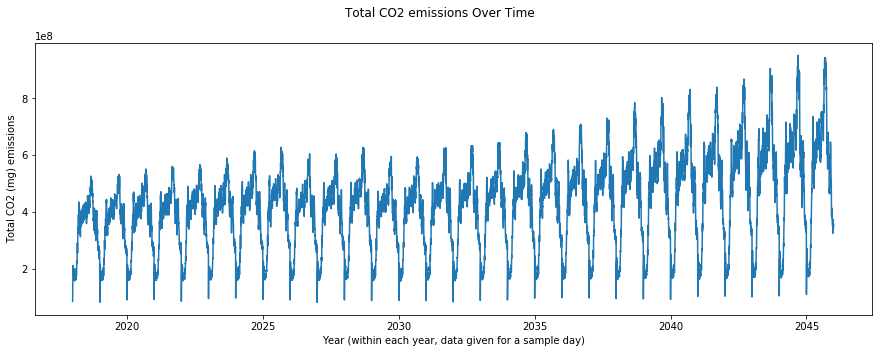

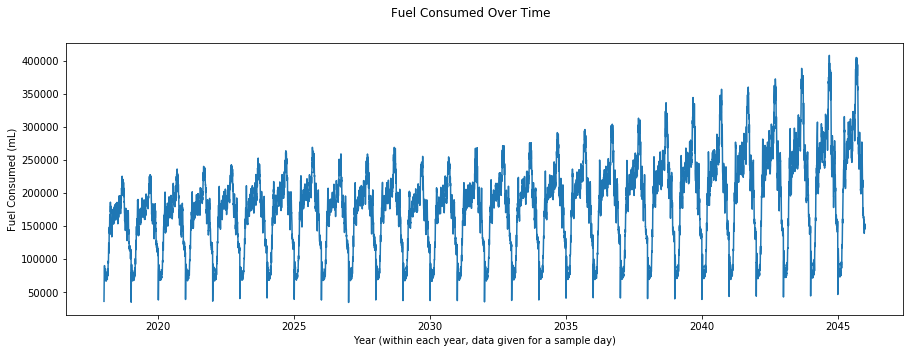

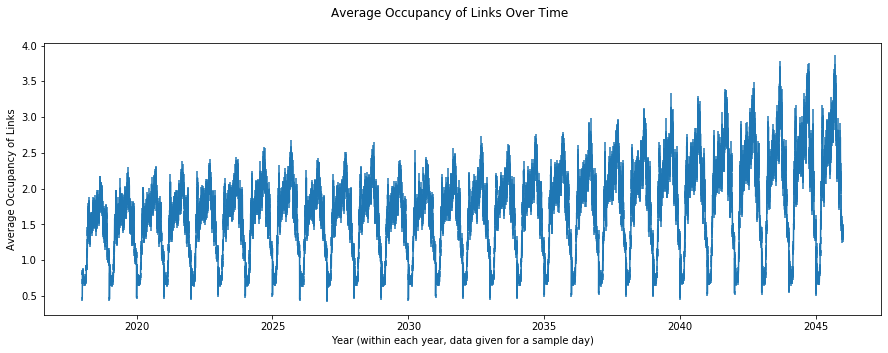

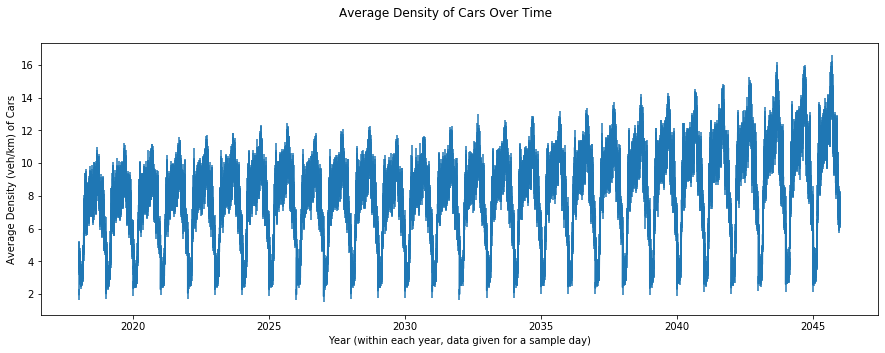

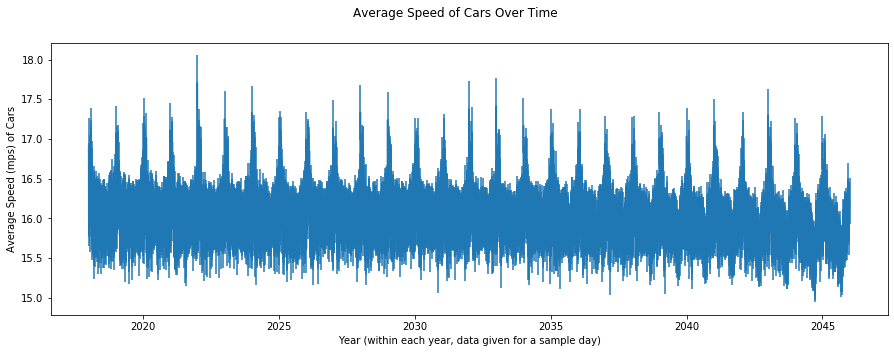

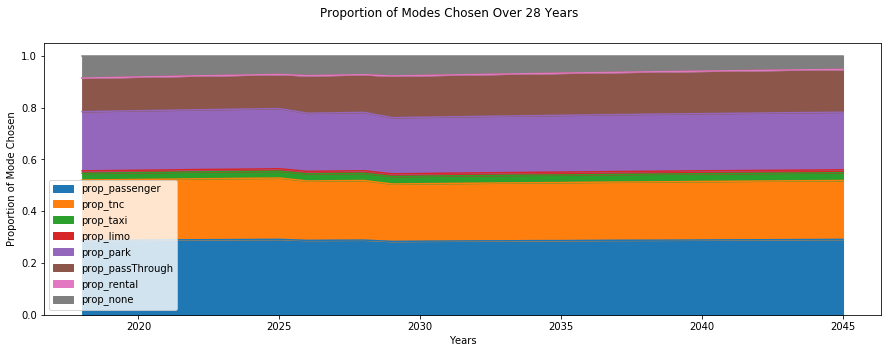

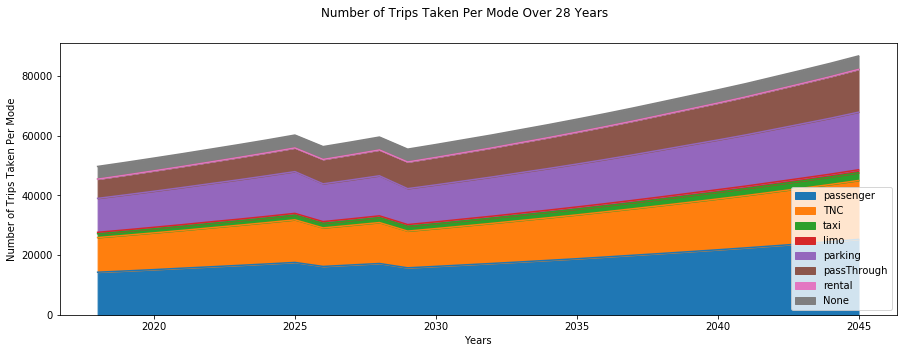

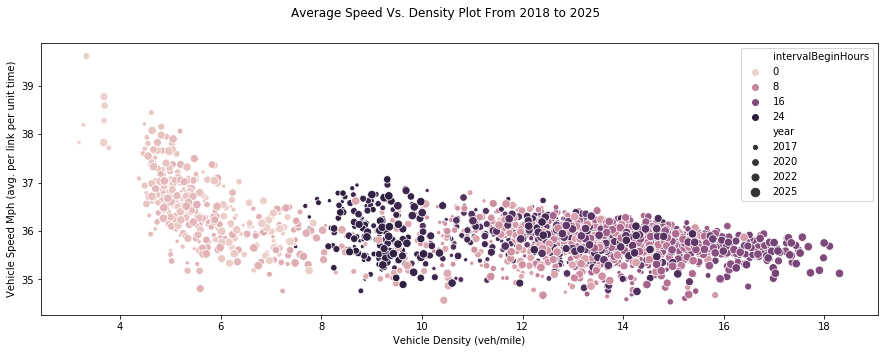

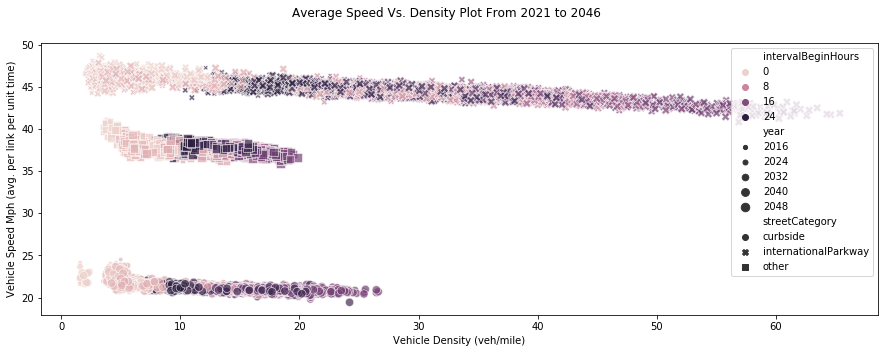

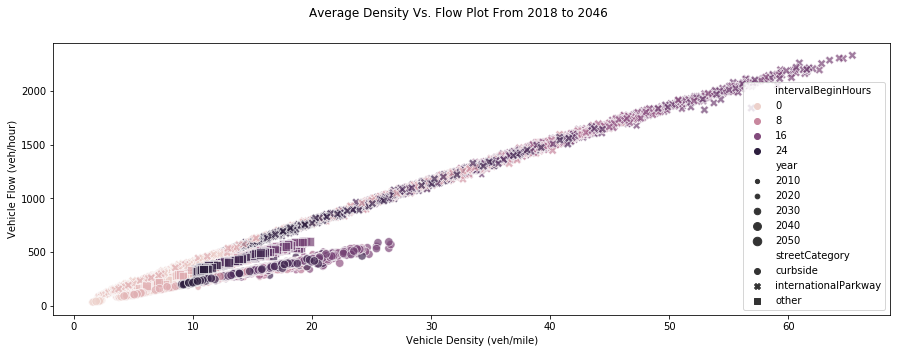

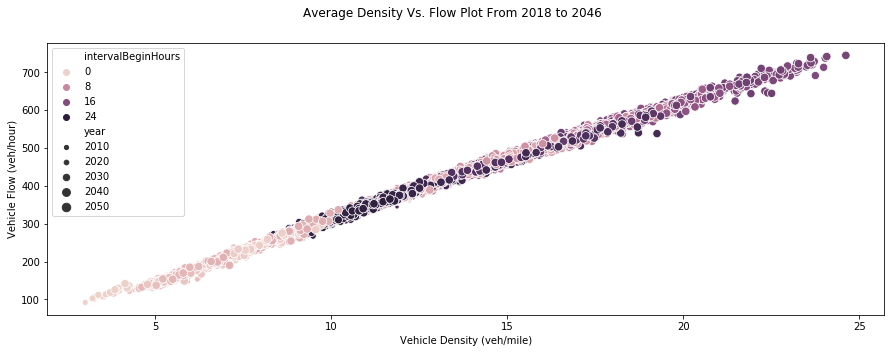

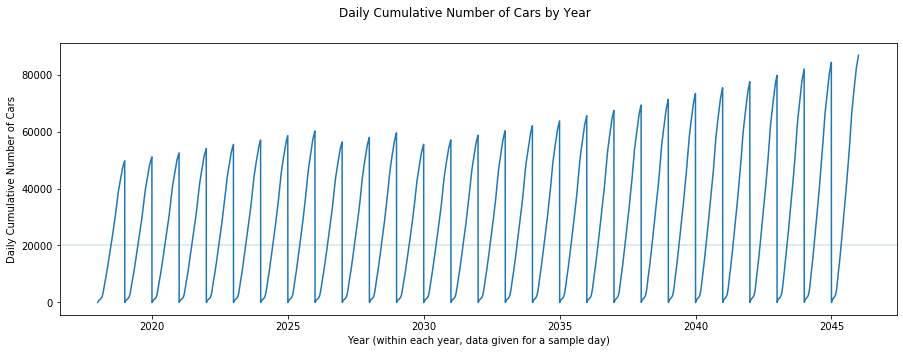

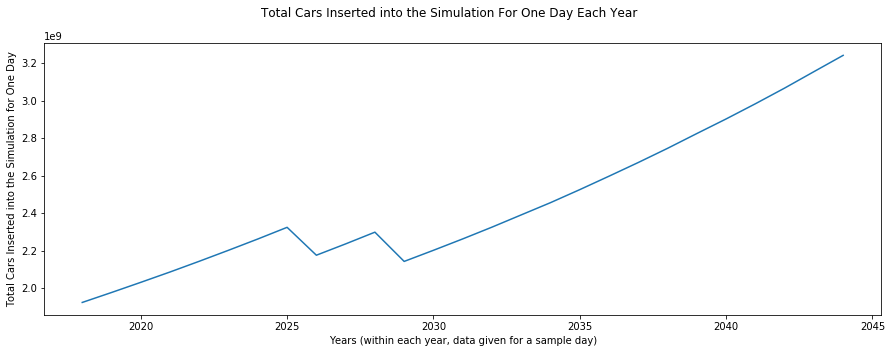

In [17]:
def run_suite_of_graphs(fp_in, fp_out, savename_tag):
    """
    Calls various graphs with pre-specified columns to create a snapshot of a single sumo simulation output.
    
    args: 
    fp_in: a string of the filepath to a folder which contains sumo output files (edge-based, edge-emissions, summary,
           and trip-based)
    fp_out: a string of the filepath to the folder where you would like the generated graphs to be saved.
    savename_tag: (string) will save each graph that is generated with this name inserted right before the ".png"
    
    returns: Nothing returned. Saves graphs to specified folder.
    """
    make_timeseries_graph(fp_in = fp_in, fp_out = fp_out, savename_tag = savename_tag,
                          file_type = 'edge_emmisions',
                         colname = 'edge_CO2_abs',
                         operation = "sum",
                         y_axis_label = "Total CO2 (mg) emissions",
                         fig_title_str = "Total CO2 emissions Over Time",
                         savefig_title_str = "co2_emissions_timeseries_")
    make_timeseries_graph(fp_in = fp_in, fp_out = fp_out, savename_tag = savename_tag,
                          file_type = 'edge_emmisions',
                         colname = 'edge_fuel_abs',
                         operation = "sum",
                         y_axis_label = "Fuel Consumed (mL)",
                         fig_title_str = "Fuel Consumed Over Time",
                         savefig_title_str = "fuel_consumed_timeseries_")
   
    make_timeseries_graph(fp_in = fp_in, fp_out = fp_out, savename_tag = savename_tag,
                          file_type = 'edges_out',
                         colname = 'edge_occupancy',
                         operation = "mean",
                         y_axis_label = "Average Occupancy of Links",
                         fig_title_str = "Average Occupancy of Links Over Time",
                         savefig_title_str = "avg_occupancy_timeseries_",
                         plot_with_error = True,
                         error_type = "sem")
    make_timeseries_graph(fp_in = fp_in, fp_out = fp_out, savename_tag = savename_tag,
                          file_type = 'edges_out',
                         colname = 'edge_density',
                         operation = "mean",
                         y_axis_label = "Average Density (veh/km) of Cars",
                         fig_title_str = "Average Density of Cars Over Time",
                         savefig_title_str = "avg_density_timeseries_",
                         plot_with_error = True,
                         error_type = "sem")
    #sumo notes: since slow vehicles spend more time on the edge, they have a proportionally bigger influence on avg speed
    make_timeseries_graph(fp_in = fp_in, fp_out = fp_out, savename_tag = savename_tag,
                          file_type = 'edges_out',
                         colname = 'edge_speed',
                         operation = "mean",
                         y_axis_label = "Average Speed (mps) of Cars",
                         fig_title_str = "Average Speed of Cars Over Time",
                         savefig_title_str = "avg_speed_timeseries_",
                         plot_with_error = True,
                         error_type = "sem")
    
    # mode graphs by percentage and by count
    make_mode_graph(fp_in = fp_in, fp_out = fp_out, savename_tag = savename_tag)
    make_mode_graph(fp_in = fp_in, fp_out = fp_out, savename_tag = savename_tag, graph_type = "counts")
    
    #speed vs. density graphs
    make_avg_speed_vs_density_graph(fp_in = fp_in, fp_out = fp_out, savename_tag = savename_tag, max_year = 7)
    make_avg_speed_vs_density_graph(fp_in = fp_in, fp_out = fp_out, savename_tag = savename_tag,
                                    min_year = 3, max_year = 28,
                                    group_on_street_cat = True, alpha = 0.7)
                                    #fig_title = "Average Speed Vs. Density Plot With 10% Transit")
    #make density vs. flow graphs...
    make_avg_speed_vs_density_graph(fp_in = fp_in, fp_out = fp_out, savename_tag = savename_tag,
                                    col_1 = "edge_density",
                                    col_2 = "edge_flow",
                                    group_on_street_cat = True, alpha = 0.7,
                                    xlabel = "Vehicle Density (veh/mile)",
                                    ylabel = "Vehicle Flow (veh/hour)",
                                    fig_title_start = "Average Density Vs. Flow Plot",
                                    save_fig_name = "avgDensityVsFlowPlot")
    
    make_avg_speed_vs_density_graph(fp_in = fp_in, fp_out = fp_out, savename_tag = savename_tag,
                                    col_1 = "edge_density",
                                    col_2 = "edge_flow",
                                    xlabel = "Vehicle Density (veh/mile)",
                                    ylabel = "Vehicle Flow (veh/hour)",
                                    fig_title_start = "Average Density Vs. Flow Plot",
                                    save_fig_name = "avgDensityVsFlowPlot")
    
    #Check that the number of cars arriving at their destination each year is increasing
    # (that scaling of demand is increasing as expected)
    make_timeseries_graph(fp_in = fp_in, fp_out = fp_out, savename_tag = savename_tag,
                          file_type = 'edges_out',
                         colname = 'edge_arrived',
                         operation = "sum",
                         y_axis_label = "Daily Cumulative Number of Cars",
                         fig_title_str = "Daily Cumulative Number of Cars by Year",
                         savefig_title_str = "arrived_daily_cumulative_sum_timeseries",
                         daily_cumulative = True,
                         hline_height = 20000, max_year = 28)
    make_sumo_summary_graph(fp_in = fp_in, fp_out = fp_out, savename_tag = savename_tag,
                            colname = 'step_inserted',
                            operation = "sum",
                            y_axis_label = "Total Cars Inserted into the Simulation for One Day",
                            fig_title_str = "Total Cars Inserted into the Simulation For One Day Each Year",
                            savefig_title_str = "summary_inserted_timeseries",
                            show_x_years = 27)

run_suite_of_graphs(fp_in = "./sumoOutputs/med/",
                    fp_out = "./sumoOutputs/medGraphs/",
                    savename_tag = "")


# Part 2) Compare Different Sumo Scenarios on the Same Graph
### Each separate input file path (fps_in) will create a different line on the line graph

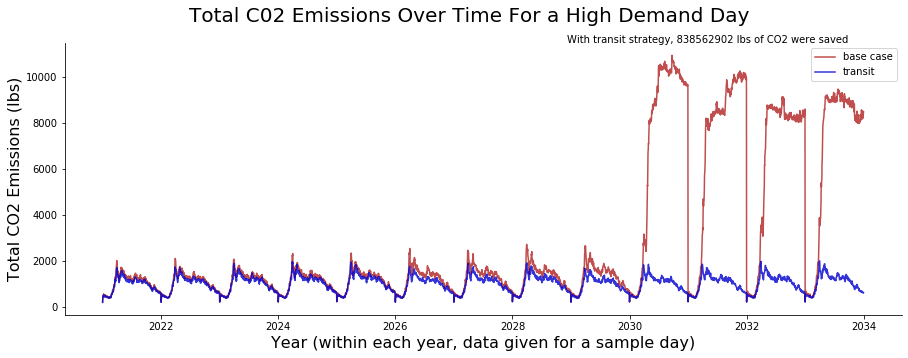

In [13]:
co2_df = make_timeseries_multi_graph(fps_in = ["./sumoOutputs/baseCaseHigh/",
                                               "./sumoOutputs/high/"],
                            fp_out = "./sumoOutputs/graphsForPaper/",
                            col_tags = ["", "_transitHighDay"],
                            savename_tag = "_high", file_type = "edge_emmisions",
                            colname = 'edge_CO2_abs',
                            operation = "sum",
                            pct = None,
                            conversion_factor = 2.20462e-6, # mg_to_lbs
                            y_axis_label = "Total CO2 Emissions (lbs)",
                            fig_title_str = "Total C02 Emissions Over Time For a High Demand Day",
                            savefig_title_str = "co2_timeseries_baseline_and_transit",
                            hline_height = None,
                            plot_with_error = False,
                            error_type = "sem",
                            colors = ["firebrick", "mediumblue"], alphas = [0.8, 0.8],
                            labels = ["base case", "transit"], 
                            annotate = False,
                            units = "lbs",
                            unitsOf = "of CO2",
                            min_year = 3,
                            max_years = 15)

# Part 3) Compare scenarios using the summary files from sumo
### optionally make multigraphs for the sumo summary files

,year,step_arrived,step_arrived_transitTenPct
0,2018,2081891632,2053135786
1,2019,2144351223,2110165494
2,2020,2206696793,2170314647
3,2021,2269055065,2230139860
4,2022,2352397640,2294155875
5,2023,2414695307,2354947680
6,2024,2477262032,2422173652
7,2025,2560295873,2488426486


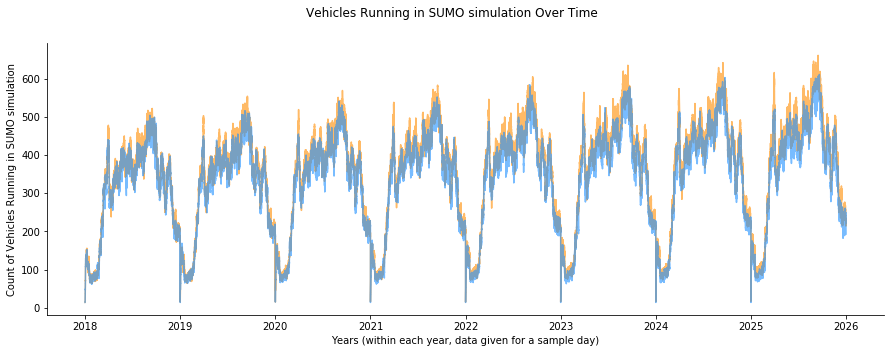

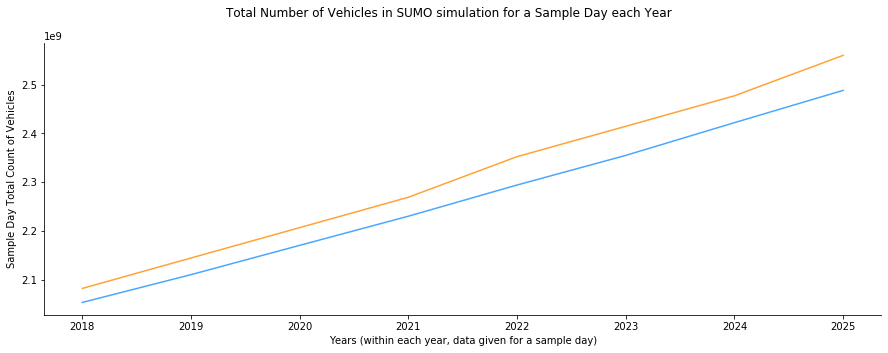

In [16]:
fps_in = ["./sumoOutputs/base_case_for_abstract/", "./sumoOutputs/tenPctMedium/"]
fp_out = "./sumoOutputs/graphsForAbstract/"
col_tags = ["", "_transitTenPct"]
make_sumo_summary_multi_graph_sec_by_sec(fps_in = fps_in, fp_out = fp_out, col_tags = col_tags,
                                         savename_tag = "", colname = "step_running",
                                         y_axis_label = "Count of Vehicles Running in SUMO simulation",
                                         fig_title_str = "Vehicles Running in SUMO simulation Over Time",
                                         savefig_title_str = "vehs_running_by_sec",
                                         show_x_years = 8, colors = ["darkorange", "dodgerblue"], alpha = 0.6)
make_sumo_summary_multi_graph(fps_in = fps_in, fp_out = fp_out, col_tags = col_tags,
                                  savename_tag = "", colname = "step_arrived",
                                  operation = "sum",
                                  y_axis_label = "Sample Day Total Count of Vehicles",
                                  fig_title_str = "Total Number of Vehicles in SUMO simulation for a Sample Day each Year",
                                  savefig_title_str = "total_vehs_",
                                  show_x_years = 8, colors = ["darkorange", "dodgerblue"], alpha = 0.8)